# Julia Academy

## Data Science Course

# 7. Classical Regression Algorithms in Julia

**Huda Nassar**

**Source:** https://github.com/JuliaAcademy/DataScience/blob/main/07.%20Regression.ipynb

We will use different implementations of classical regression algorithms in Julia and compare them at the end. We will use the Zillow rental data.

In [16]:
using Plots
using Statistics
using StatsBase
using PyCall
using DataFrames
using GLM
using Tables
using XLSX
using MLBase
using RDatasets
using LsqFit
using DataStructures

In [5]:
ENV["LINES"], ENV["COLUMNS"] = 15, 200;

In [6]:
zillow_xls = XLSX.readxlsx("data/zillow_data_download_april2020.xlsx")

XLSXFile("zillow_data_download_april2020.xlsx") containing 4 Worksheets
            sheetname size          range        
-------------------------------------------------
 MonthlyListings_City 8348x91       A1:CM8348    
     Sale_counts_city 28760x148     A1:ER28760   
Sales_median_price_c… 3767x148      A1:ER3767    
                 meta 1x1           A1:A1        


In the real estate industry, a measure of how well a particular market is doing is measured by the ratio of houses sold to the total number of listings. We will try to regress this variable.

In [8]:
sale_counts = zillow_xls["Sale_counts_city"][:]
sale_counts_df = DataFrame(sale_counts[2:end,:], Symbol.(sale_counts[1,:]))

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,6181,New York,New York,1,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,12447,Los Angeles,California,2,1446,1705,1795,1890,2072,1876,1981,2195,1579,2068,1523,1514,1976,2128,2060,2536,2538
3,39051,Houston,Texas,3,2926,3121,3220,3405,3352,2962,2017,2595,1865,2472,1776,1918,2472,2333,2443,2918,2923
4,17426,Chicago,Illinois,4,2910,3022,2937,3224,3464,3371,2979,2869,1915,2110,1897,1618,2284,2520,2366,2938,3015
5,6915,San Antonio,Texas,5,1479,1529,1582,1761,1678,1468,1480,1475,949,1178,856,1016,1283,1221,1339,1777,1752
6,13271,Philadelphia,Pennsylvania,6,1609,1795,1709,1914,1984,1739,1635,1598,1169,1414,1152,1029,1199,1368,1412,1586,1853
7,40326,Phoenix,Arizona,7,1310,1519,1654,1743,1975,1809,1965,2074,1435,2045,1891,2174,2809,2981,3172,3797,3468
8,18959,Las Vegas,Nevada,8,1618,1856,1961,2022,2219,2248,2207,2372,1880,2251,2087,2097,2884,2948,2945,3441,3237
9,54296,San Diego,California,9,772,1057,1195,1115,1272,1171,1193,1319,873,1052,886,860,1069,1232,1172,1390,1416


In [10]:
monthly_listings = zillow_xls["MonthlyListings_City"][:]
monthly_listings_df = DataFrame(monthly_listings[2:end,:], Symbol.(monthly_listings[1,:]))

,SizeRank,RegionID,RegionName,RegionType,StateName,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,6181,New York,City,NY,28904,28155,30596,31371,31851,29137,28608,26679,25920,29150,29092,25519,26630,28054,28379,29281
2,2,12447,Los Angeles,City,CA,6431,6613,6467,6756,7059,6870,7445,7282,7112,7700,6644,5839,6224,6227,7037,7951
3,3,39051,Houston,City,TX,11696,11737,12291,12475,13305,12329,12818,12033,11450,11253,10193,9304,9600,9270,9645,10900
4,4,17426,Chicago,City,IL,9523,9609,9772,10356,11035,10146,10458,10266,10080,10190,9185,8267,8310,8570,9323,11070
5,5,6915,San Antonio,City,TX,7223,7170,7438,7542,8000.0,7316,7365,7181,6420,6764,6088,5674,5927,5720,6315,6637
6,6,13271,Philadelphia,City,PA,7505,7266,7578,7874,8446,8198,8228,7732,7730,8166,7773,7221,7215,6713,7142,8390
7,7,40326,Phoenix,City,AZ,6232,5720,5872,6191,6438,6045,6328,6218,6341,7491,7382,7088,7876,7907,8181,8833
8,8,18959,Las Vegas,City,NV,7027,6218,6199,6238,6916,6527,7133,7678,8017,9094,8734,8053,8352,7998,8553,9250
9,9,54296,San Diego,City,CA,4121,3844,3932,4079,4579,4513,4706,4579,4051,4471,3979,3450,3712,3529,3793,4442


Let's look at just one month:

In [11]:


monthly_listings_2020_02 = monthly_listings_df[:, [1,2,3,4,5,end]]
rename!(monthly_listings_2020_02, Symbol("2020-02") .=> Symbol("listings"))

sale_counts_2020_02 = sale_counts_df[:, [1,end]]
rename!(sale_counts_2020_02, Symbol("2020-02") .=> Symbol("sales"));



And now we will join these datasets on `RegionID`

In [12]:
Feb2020data = innerjoin(monthly_listings_2020_02, sale_counts_2020_02, on=:RegionID) #, type="outer")
dropmissing!(Feb2020data)

,SizeRank,RegionID,RegionName,RegionType,StateName,listings,sales
,Any,Any,Any,Any,Any,Any,Any
1,1,6181,New York,City,NY,21164,4054
2,2,12447,Los Angeles,City,CA,5553,1522
3,3,39051,Houston,City,TX,11654,2682
4,4,17426,Chicago,City,IL,9417,2100
5,5,6915,San Antonio,City,TX,6887,1626
6,6,13271,Philadelphia,City,PA,5110,1620
7,7,40326,Phoenix,City,AZ,4419,2325
8,8,18959,Las Vegas,City,NV,6749,2547
9,10,38128,Dallas,City,TX,4317,1292


Now let's get some key variables

In [14]:
sales = Feb2020data[:, :sales]
listing_counts = Feb2020data[:, :listings];

And now let's choose 10 states to analyse:

In [18]:
states = Feb2020data[:, :StateName]

state_counts = counter(states)
state_count_values = values(state_counts.map)
top_states_idx = sortperm(collect(state_count_values), rev=true)[1:10]
top_states = collect(keys(state_counts.map))[top_states_idx]



10-element Array{Any,1}:
 "CA"
 "FL"
 "IL"
 "NJ"
 "MI"
 "TX"
 "PA"
 "OH"
 "NC"
 "NY"

## OLS Regression

Now let's run OLS regression for each state

(state, coef(ols)) = ("CA", [0.29595375979515304])
(state, coef(ols)) = ("FL", [0.16693529057344902])
(state, coef(ols)) = ("IL", [0.22291703276169347])
(state, coef(ols)) = ("NJ", [0.25556391864492345])
(state, coef(ols)) = ("MI", [0.2925436820147375])
(state, coef(ols)) = ("TX", [0.24732835944836878])
(state, coef(ols)) = ("PA", [0.310066636803275])
(state, coef(ols)) = ("OH", [0.4569949754409864])
(state, coef(ols)) = ("NC", [0.4800747758857476])
(state, coef(ols)) = ("NY", [0.19151984869233082])


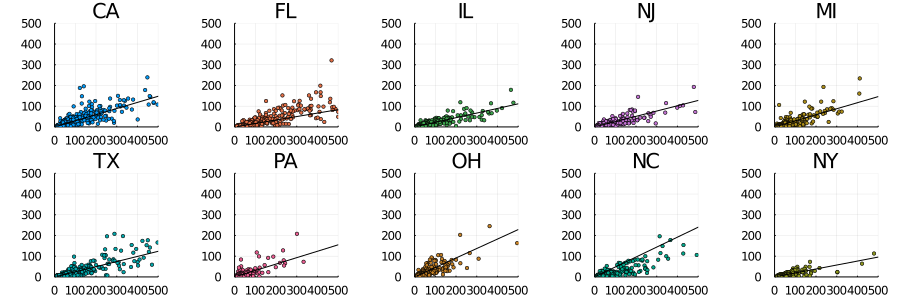

In [44]:
all_plots = Array{Plots.Plot}(undef, 10)
for (i, state) in enumerate(top_states)
    this_state_idx = findall(Feb2020data[:, :StateName].==state)
    data = DataFrame(X=float.(listing_counts[this_state_idx]), Y=float.(sales[this_state_idx]))
    # regression
    ols = GLM.lm(@formula(Y ~ 0 + X), data)  # no intercept
    # plot fit
    all_plots[i] = scatter(data.X, data.Y,
                           title=state,
                           color=i,
                           markersize=2,
                           legend=false,
                           xlim=(0,500),
                           ylim=(0,500),
                           aspect_ratio=:equal
                   )
    plot!(data.X, predict(ols), color=:black)
    @show state, coef(ols)
end
plot(all_plots..., layout=(2,5), size=(900, 300))



Let's now introduce an intercept

(state, coef(ols)) = ("CA", [6.8030864646283105, 0.28798374289950357])
(state, coef(ols)) = ("FL", [19.12625581923338, 0.15510798334559428])
(state, coef(ols)) = ("IL", [0.6626439876883512, 0.2226325765807212])
(state, coef(ols)) = ("NJ", [-1.9635911642225743, 0.2650303535602978])
(state, coef(ols)) = ("MI", [-0.9181942041703457, 0.29768705032459525])
(state, coef(ols)) = ("TX", [5.241220767319295, 0.24566620049636262])
(state, coef(ols)) = ("PA", [-0.2136244857995291, 0.3101955410309725])
(state, coef(ols)) = ("OH", [-6.026958739166814, 0.47909280478486926])
(state, coef(ols)) = ("NC", [-24.60003985327959, 0.5302793903364814])
(state, coef(ols)) = ("NY", [-0.20048638474403213, 0.191535092167981])


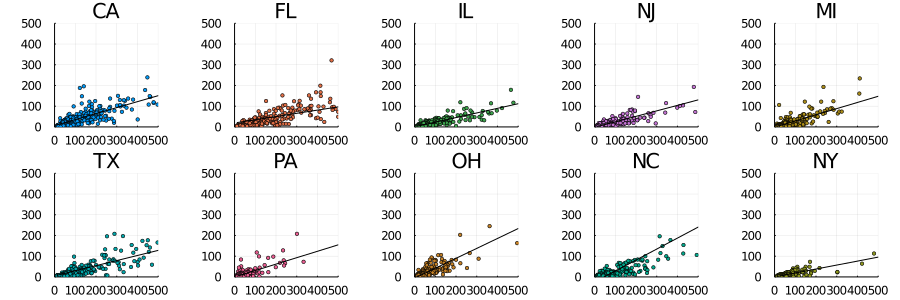

In [45]:
all_plots = Array{Plots.Plot}(undef, 10)
for (i, state) in enumerate(top_states)
    this_state_idx = findall(Feb2020data[:, :StateName].==state)
    data = DataFrame(X=float.(listing_counts[this_state_idx]), Y=float.(sales[this_state_idx]))
    # regression
    ols = GLM.lm(@formula(Y ~ X), data)
    # plot fit
    all_plots[i] = scatter(data.X, data.Y,
                           title=state,
                           color=i,
                           markersize=2,
                           legend=false,
                           xlim=(0,500),
                           ylim=(0,500),
                           aspect_ratio=:equal
                   )
    plot!(data.X, predict(ols), color=:black)
    @show state, coef(ols)
end
plot(all_plots..., layout=(2,5), size=(900, 300))



Alternatively let's compare each state on the same set of axes. We'll highlight three states:

(state, coef(ols)) = ("CA", [0.29595375979515304])
(state, coef(ols)) = ("FL", [0.16693529057344902])
(state, coef(ols)) = ("IL", [0.22291703276169347])
(state, coef(ols)) = ("NJ", [0.25556391864492345])
(state, coef(ols)) = ("MI", [0.2925436820147375])
(state, coef(ols)) = ("TX", [0.24732835944836878])
(state, coef(ols)) = ("PA", [0.310066636803275])
(state, coef(ols)) = ("OH", [0.4569949754409864])
(state, coef(ols)) = ("NC", [0.4800747758857476])
(state, coef(ols)) = ("NY", [0.19151984869233082])


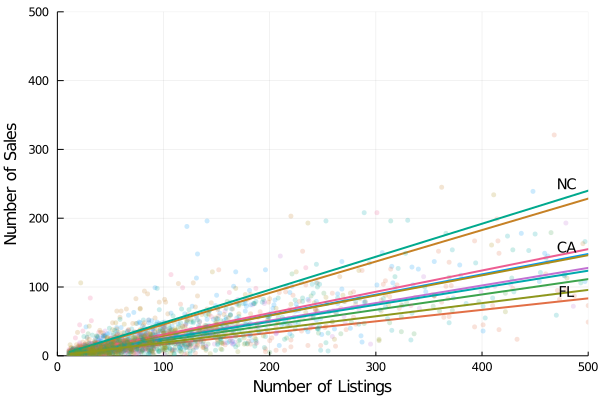

In [46]:
plot()
for (i, state) in enumerate(top_states)
    this_state_idx = findall(Feb2020data[:, :StateName].==state)
    data = DataFrame(X=float.(listing_counts[this_state_idx]), Y=float.(sales[this_state_idx]))
    # regression
    ols = GLM.lm(@formula(Y ~ 0 + X), data)  # no intercept
    # plot fit
    scatter!(data.X, data.Y,
             color=i, alpha=0.2, 
             markersize=2, marker=(3,3,stroke(0)), 
             legend=false, xlim=(0,500), ylim=(0,500)
    )
    if state == "NC" || state == "CA" || state == "FL"
        annotate!([(500-20, 10+coef(ols)[1]*500, text(state,10))])
    end
    plot!(data.X, predict(ols), color=i, linewidth=2)
    @show state, coef(ols)
end
xlabel!("Number of Listings")
ylabel!("Number of Sales")


## Logistic Regression

We will now look at logistic regression where the target variable is binary and is binomial distributed

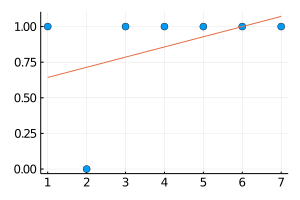

In [47]:
# toy example showing how ols cannot model this space
data = DataFrame(X=[1,2,3,4,5,6,7], Y=[1,0,1,1,1,1,1])
linear_reg = lm(@formula(Y ~ X), data)
scatter(data[!,:X],data[!,:Y],legend=false,size=(300,200))
plot!(1:7,predict(linear_reg))

We'll use the cats dataset from `RDatasets` where we will try to predict the sex of a cat from its bodyweight (kg) and heart weight (g)

In [48]:
cats = dataset("MASS", "cats")

,Sex,BWt,HWt
,Cat…,Float64,Float64
1,F,2.0,7.0
2,F,2.0,7.4
3,F,2.0,9.5
4,F,2.1,7.2
5,F,2.1,7.3
6,F,2.1,7.6
7,F,2.1,8.1
8,F,2.1,8.2
9,F,2.1,8.3


Now let's map the sex of each cat to a binary 0-1 value:

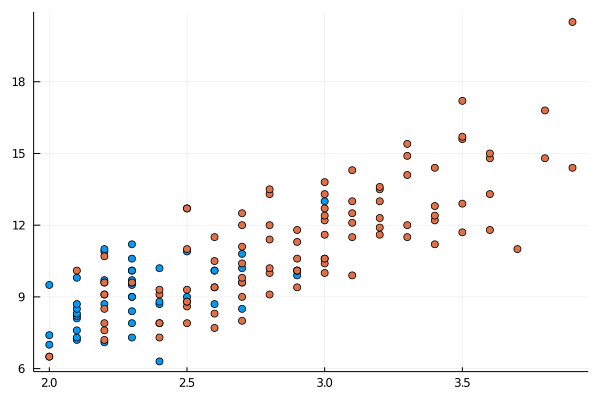

In [53]:
lmap = MLBase.labelmap(cats[!, :Sex])
class_idx = MLBase.labelencode(lmap, cats[!, :Sex])
scatter(cats[!,:BWt], cats[!,:HWt], color=class_idx, legend=false)  # blue is female, orange is male

In [54]:
lmap

LabelMap (with 2 labels):
[1] F
[2] M


To fit a logistic regression model using `GLM.jl` we just need to specify the target distribution to Binomial and the link function to the logit function

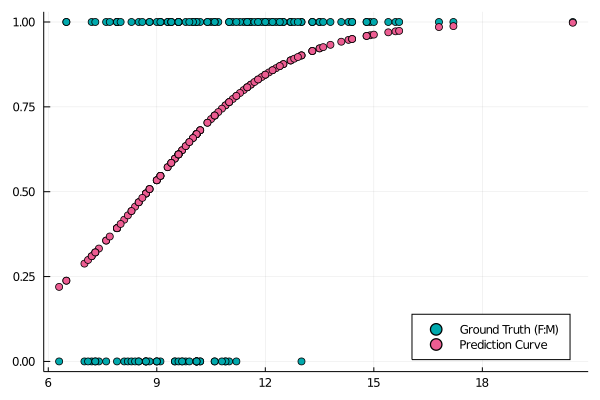

In [59]:
data = DataFrame(X=cats[!, :HWt], Y=class_idx.-1)
logit_fit = glm(@formula(Y ~ X), data, Binomial(), LogitLink())

scatter(data.X, data.Y, label="Ground Truth (F:M)", color=6)
scatter!(data.X, predict(logit_fit), label="Prediction Curve", color=7)
plot!(legend=:bottomright)

## Nonlinear Regression

Let's use `LsqFit.jl` which will use least squares to minimize the error between an arbitrary function and the data

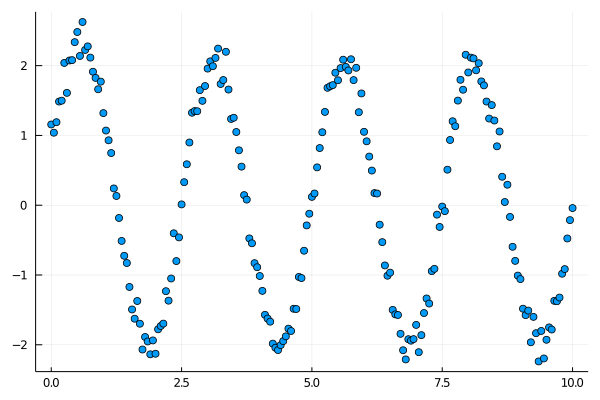

In [63]:
x = 0:0.05:10
y = 1*exp.(-x*2) + 2*sin.(0.8*pi*x) + 0.15*randn(length(x))
scatter(x, y, legend=false)

To use `LsqFit` we can specify a parametric model. In this case we know how the data was generated:

In [66]:
@. model(x, p) = p[1]*exp.(-x*p[2]) + p[3]*sin.(0.8*pi*x)
p0 = [0.5, 0.5, 0.5]  # initial values
lsq_fit = LsqFit.curve_fit(model, x, y, p0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.9644466444329396, 1.9798151200822434, 2.039149816237412], [-0.19272950906489084, 0.08993660097149214, 0.1084247529138298, -0.01813723663799971, 0.1335251278065337, -0.2525062931443365, 0.318354144618491, -0.0208078353016381, 0.0797322546725745, -0.09632131827185075  …  -0.09423897335177633, 0.059852489899006045, -0.20090156413794236, -0.01962006732973509, 0.12482091826796249, -0.0004976632757422994, 0.16506759911889568, -0.030287227618856827, -0.04171570826218479, 0.04058316573071587], [1.0000000000052196 0.0 0.0; 0.9057510807421708 -0.04367742952852528 0.1253332335651367; … ; 2.7868081755007835e-9 -2.672144441019117e-8 -0.12533323356288892; 2.5221072344889904e-9 -2.4324686887608393e-8 0.0], true, Float64[])

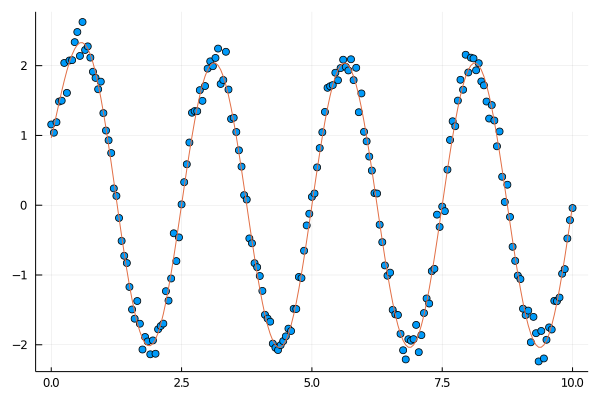

In [67]:
p = lsq_fit.param
lsq_fitted_y =  p[1]*exp.(-x*p[2]) + p[3]*sin.(0.8*pi*x)

scatter(x, y, legend=false)
plot!(x, lsq_fitted_y)

Just for fun, let's try a polynomial regression

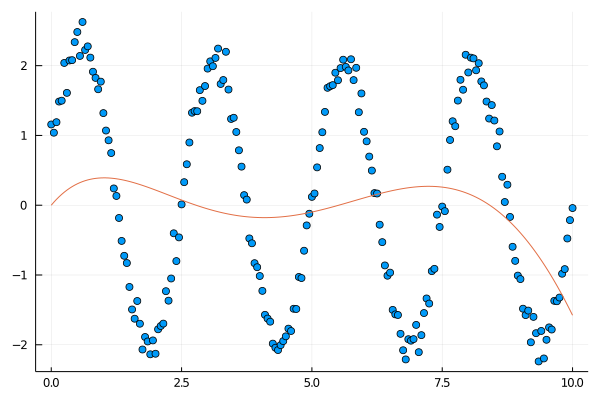

In [77]:
@. model(x,p) = p[1]*x + p[2]*x^2 + p[3]*x^3 + p[4]*x^4 + p[5]*x^5
p0 = [0.5, 0.5, 0.5, 0.5, 0.5]  # initial values
lsq_fit = LsqFit.curve_fit(model, x, y, p0)

p = lsq_fit.param
x = collect(x)
lsq_fitted_y =  p[1]*x + p[2]*x.^2 + p[3]*x.^3 + p[4]*x.^4 + p[5]*x.^5
scatter(x, y, legend=false)
plot!(x, lsq_fitted_y)